In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()

In [3]:
def moca2(nic, njc, r, u, v, X, Y):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    def lin_fit(x, y):
        p = np.polyfit(x, y, 1)
        y_pred = np.polyval(p, x)
        ss_tot, ss_res = np.sum((y - np.mean(y))**2), np.sum((y - y_pred)**2)
        r2 = 1.0 if ss_tot == 0 else 1 - ss_res / ss_tot
        return p[0], p[1], r2

    A1, A0, r2A = lin_fit(xx, u1)
    B1, B0, r2B = lin_fit(xx, v1)
    C1, C0, r2C = lin_fit(yy, u2)
    D1, D0, r2D = lin_fit(yy, v2)

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2

    x0 = - ( alpha*gamma + beta*C1  ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy
    

In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

-0.9687226691682653 -0.9687226691682653
70.60526568009651 -70.6052656800965
-349.96416703185145 -349.96416703185145


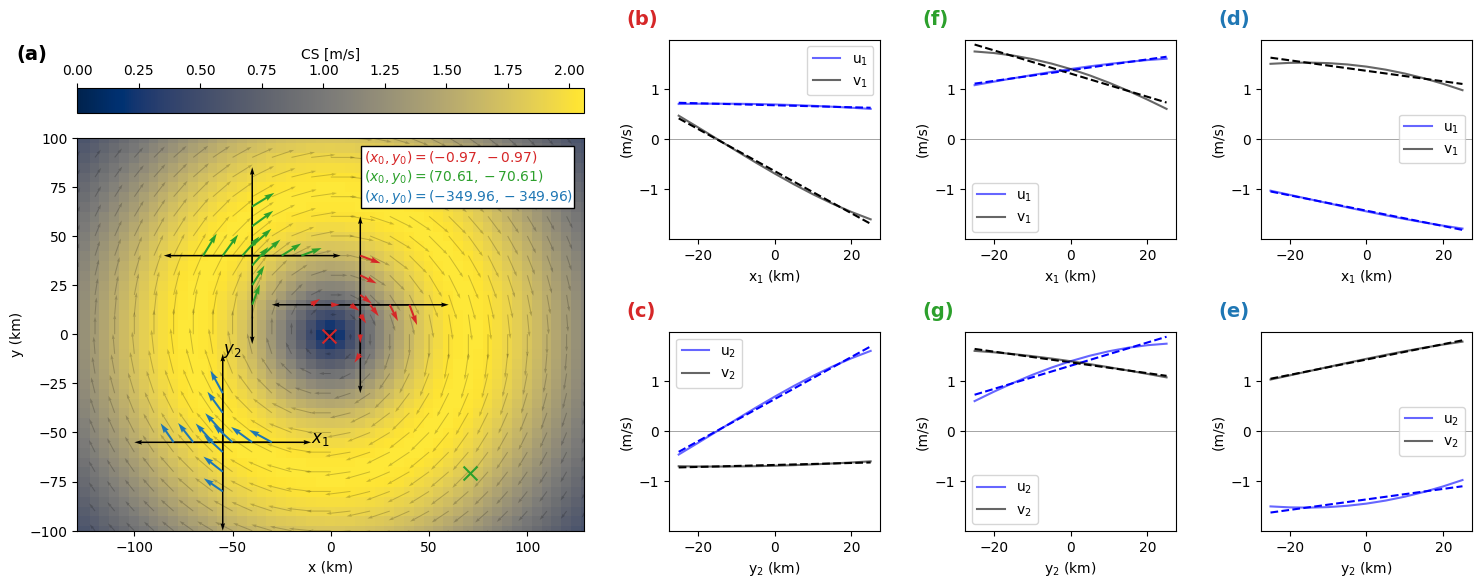

In [5]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors

colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '3' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '3' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=100, color=colours[i])

        ax_main.text(17, 88 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.77, 0.9
box_width = 0.42  # Adjust width as needed
box_height = 0.16 # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)

ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        p_u1 = np.polyfit(xx, u1, 1)
        p_v1 = np.polyfit(xx, v1, 1)

        p_u2 = np.polyfit(yy, u2, 1)
        p_v2 = np.polyfit(yy, v2, 1)
    
        ax2.plot(xx, np.polyval(p_u1, xx), 'b--')#, color=colours[i])
        ax2.plot(xx, np.polyval(p_v1, xx), 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend()
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, np.polyval(p_u2, yy), 'b--')#, color=colours[i])
        ax3.plot(yy, np.polyval(p_v2, yy), 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend()
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## MOCA2 Mod

In [6]:
# def find_root(x, y):

#     roots = np.where(np.diff(np.sign(y)))[0]

#     if roots.size == 0:
#         print('a')
#         coefficients = np.polyfit(x, y, 3)
#         polynomial = np.poly1d(coefficients)
#         roots = np.roots(polynomial)

#         R = np.abs(x[len(x)//2] - roots)
#         root = roots[np.argmin(R)]

#     elif roots.size == 1:
#         root = np.interp(0, x, y)
#         print('b')
#     else:
#         R = np.abs(x[len(x)//2] - roots)
#         root = roots[np.argmin(R)]
#         print('c')

#     return root

# def tang_at_root(x, y, root_x):
#     if root_x >= np.min(x) and root_x <= np.max(x):

#         dydx = np.gradient(y, x)
#         slope_at_root = np.interp(root_x, x, dydx)
#         intercept = np.interp(root_x, x, y) - slope_at_root * root_x
#         return slope_at_root, intercept
    
#     else:

#         coeffs = np.polyfit(x, y, 3)
#         poly_derivative = np.polyder(coeffs)
#         slope_at_root = np.polyval(poly_derivative, root_x)
#         y_at_root = np.polyval(coeffs, root_x)
#         intercept = y_at_root - slope_at_root * root_x
#         return slope_at_root, intercept

def find_root(x, y):
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)
    roots = np.roots(polynomial)

    roots = roots[np.isreal(roots)].real

    R = np.abs(x[len(x)//2] - roots)
    root = roots[np.argmin(R)]

    return root

def tang_at_root(x, y, root_x):
    coeffs = np.polyfit(x, y, 3)
    poly_derivative = np.polyder(coeffs)
    slope_at_root = np.polyval(poly_derivative, root_x)
    y_at_root = np.polyval(coeffs, root_x)
    intercept = y_at_root - slope_at_root * root_x
    
    return slope_at_root, intercept

def moca2_mod(nic, njc, r, u, v, X, Y):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    root_x = find_root(xx, v1)
    A1, A0 = tang_at_root(xx, u1, root_x)
    B1, B0 = tang_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0 = tang_at_root(yy, u2, root_y)
    D1, D0 = tang_at_root(yy, v2, root_y)
    
    r2A = np.inf if np.min(np.abs(u1)) == 0 else 1 / np.min(np.abs(u1))
    r2B = np.inf if np.min(np.abs(v1)) == 0 else 1 / np.min(np.abs(v1))
    r2C = np.inf if np.min(np.abs(u2)) == 0 else 1 / np.min(np.abs(u2))
    r2D = np.inf if np.min(np.abs(v2)) == 0 else 1 / np.min(np.abs(v2))

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2

    x0 = - ( alpha*gamma + beta*C1  ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy

In [7]:
dic_tests_mod = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2_mod(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests_mod[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

-0.019724209306378526 -0.019724209306378526
-1.335461136622726 1.3354611366228468
-3.2680206346393987 -3.2680206346393987


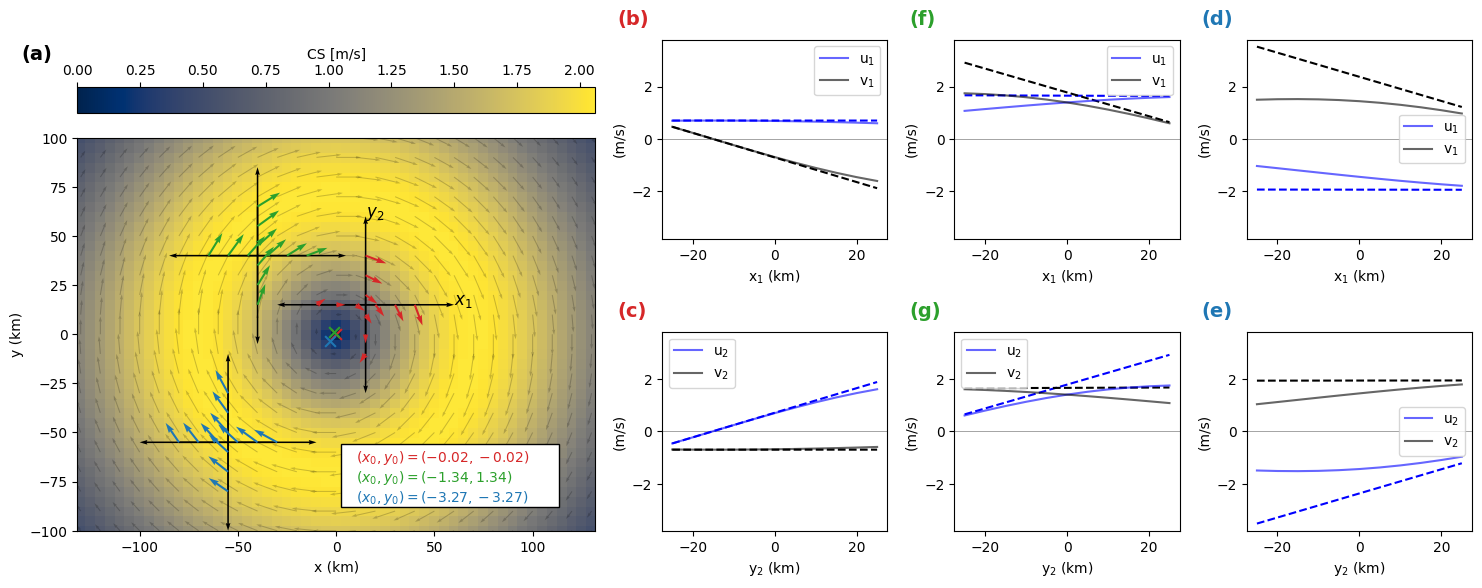

In [8]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i])
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

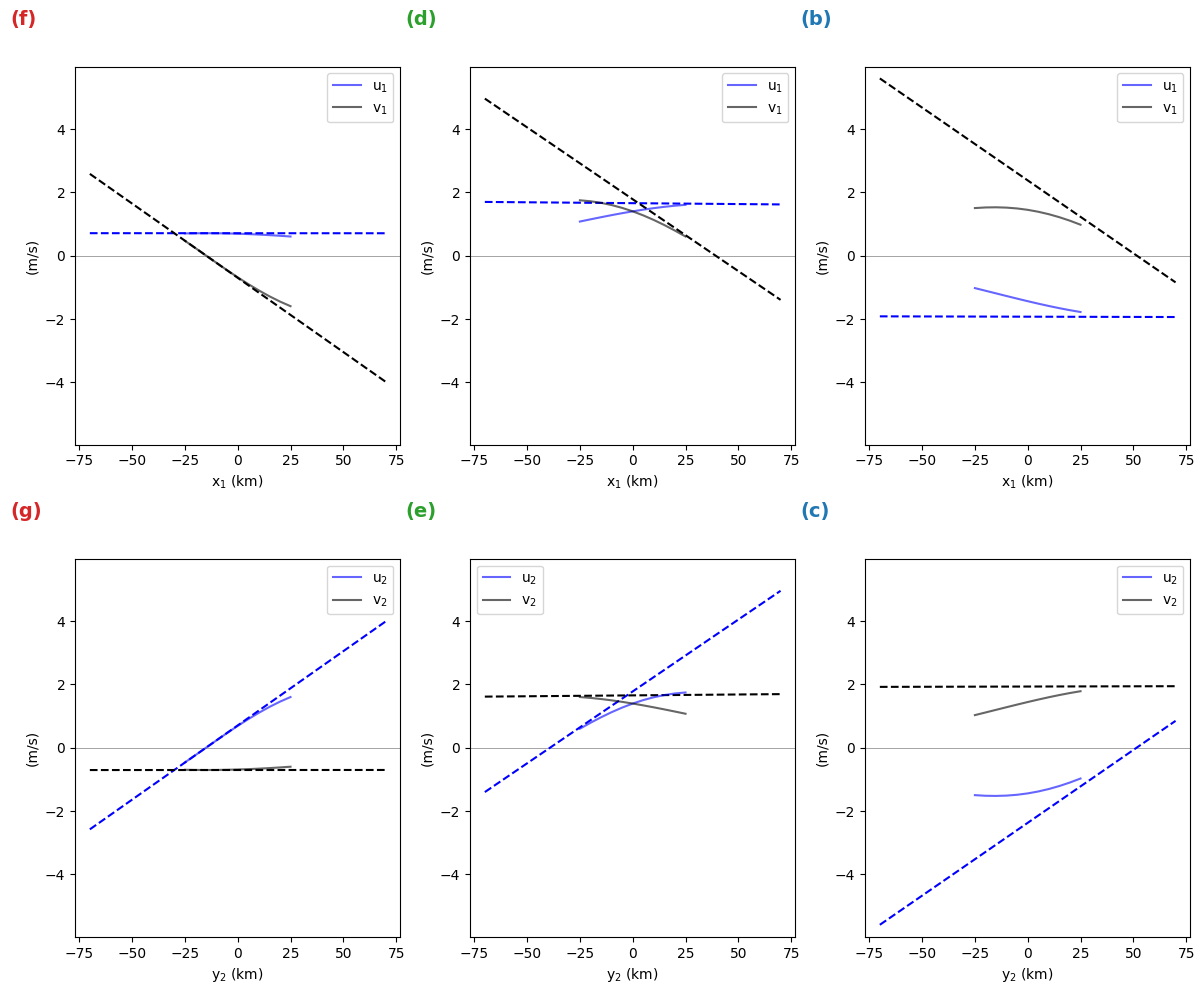

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12,10))
j = 0
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]

l = np.linspace(-70, 70, 100)
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = axs[0, j]
        ax3 = axs[1, j]
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*l + A0
        p_v1 = B1*l + B0

        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*l + C0
        p_v2 = D1*l + D0
    
        ax2.plot(l, p_u1, 'b--')#, color=colours[i])
        ax2.plot(l, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(l, p_u2, 'b--')#, color=colours[i])
        ax3.plot(l, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs.flat), max(ax.get_ylim()[1] for ax in axs.flat)
for ax in axs.flat:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [10]:
df = pd.DataFrame(columns=['x0', 'y0'])
for dic in dic_tests.values():
    df.loc[len(df)] = {'x0': dic['x0'], 'y0': dic['y0']}
df.index = dic_tests.keys()

df_mod = pd.DataFrame(columns=['x0m', 'y0m'])
for dic in dic_tests_mod.values():
    df_mod.loc[len(df_mod)] = {'x0m': dic['x0'], 'y0m': dic['y0']}
df_mod.index = dic_tests_mod.keys()

df_results = pd.concat([df, df_mod], axis=1)

df_results['ERR'] = np.hypot(df_results['x0'], df_results['y0'])
df_results['ERRm'] = np.hypot(df_results['x0m'], df_results['y0m'])

df_results['%'] = (df_results['ERR'] - df_results['ERRm']) / df_results['ERR'] * 100

df_results

,x0,y0,x0m,y0m,ERR,ERRm,%
P1,-0.968723,-0.968723,-0.019724,-0.019724,1.369981,0.027894,97.963895
P2,70.605266,-70.605266,-1.335461,1.335461,99.850924,1.888627,98.108553
P3,-349.964167,-349.964167,-3.268021,-3.268021,494.924071,4.621679,99.066184
L1,-1.270866,-1.270866,0.007483,0.007483,1.797276,0.010582,99.411210
L2,-0.968723,-0.968723,-0.019724,-0.019724,1.369981,0.027894,97.963895
L3,-0.538735,-0.538735,-0.048007,-0.048007,0.761886,0.067893,91.088876


# Elliptical Vortex

In [11]:
u, v, _, _ = calculate_eddy(q11=2, q22=2, q12=1)

In [12]:
X, Y = np.meshgrid(x, y)
nic, njc = 53, 53
r = 5

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

-4.077632709220008 -4.077632709220008
78.18740291042931 -78.18740291042931
-78.24274863196861 -78.24274863196861


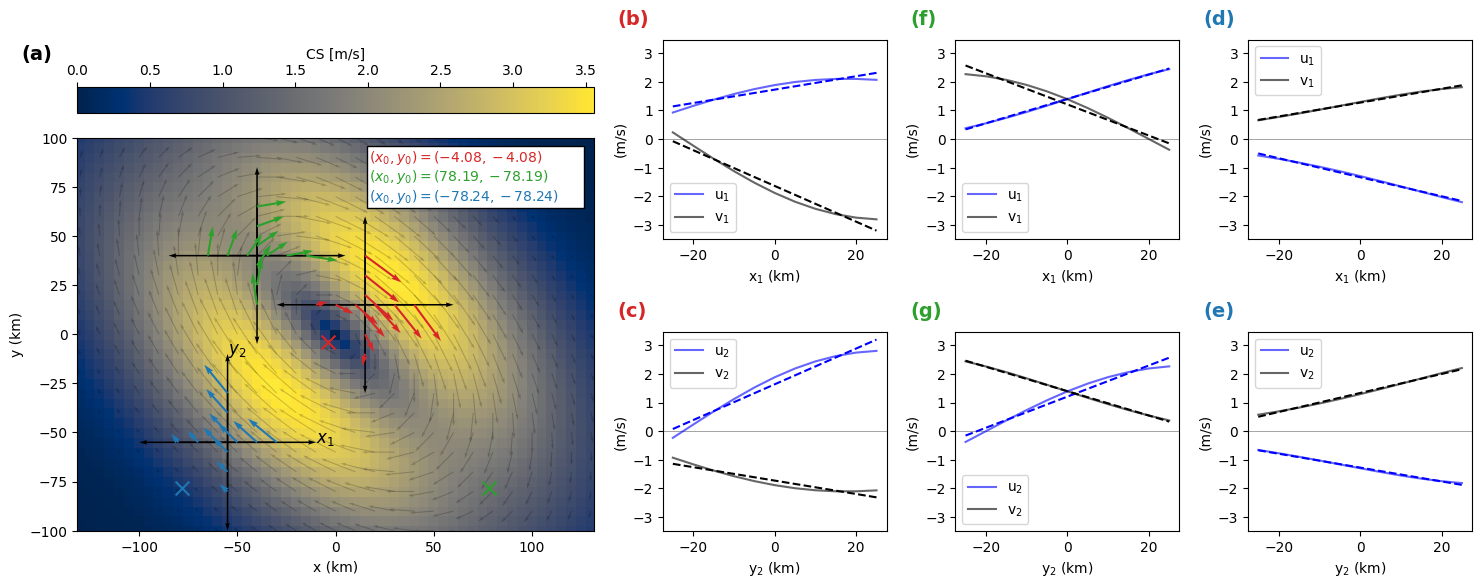

In [13]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors

colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '3' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '3' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=100, color=colours[i])

        ax_main.text(17, 88 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.77, 0.9
box_width = 0.42  # Adjust width as needed
box_height = 0.16 # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)

ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        p_u1 = np.polyfit(xx, u1, 1)
        p_v1 = np.polyfit(xx, v1, 1)

        p_u2 = np.polyfit(yy, u2, 1)
        p_v2 = np.polyfit(yy, v2, 1)
    
        ax2.plot(xx, np.polyval(p_u1, xx), 'b--')#, color=colours[i])
        ax2.plot(xx, np.polyval(p_v1, xx), 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend()
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, np.polyval(p_u2, yy), 'b--')#, color=colours[i])
        ax3.plot(yy, np.polyval(p_v2, yy), 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend()
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [14]:
dic_tests_mod = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():
    x0_rel, y0_rel, w_rel, x1_rel, y1_rel, u1_rel, v1_rel, x2_rel, y2_rel, u2_rel, v2_rel, xx_rel, yy_rel = moca2_mod(nic_rel, njc_rel, r_rel, u, v, X, Y)
    
    dic_tests_mod[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'w': w_rel, 'x1': x1_rel, 'y1': y1_rel,
        'u1': u1_rel, 'v1': v1_rel, 'x2': x2_rel, 'y2': y2_rel,
        'u2': u2_rel, 'v2': v2_rel, 'xx': xx_rel, 'yy': yy_rel, 'name': test_name
    }

0.013369631894477152 0.013369631894477152
-0.06639702813194504 0.06639702813195214
-18.68764509995333 -18.68764509995333


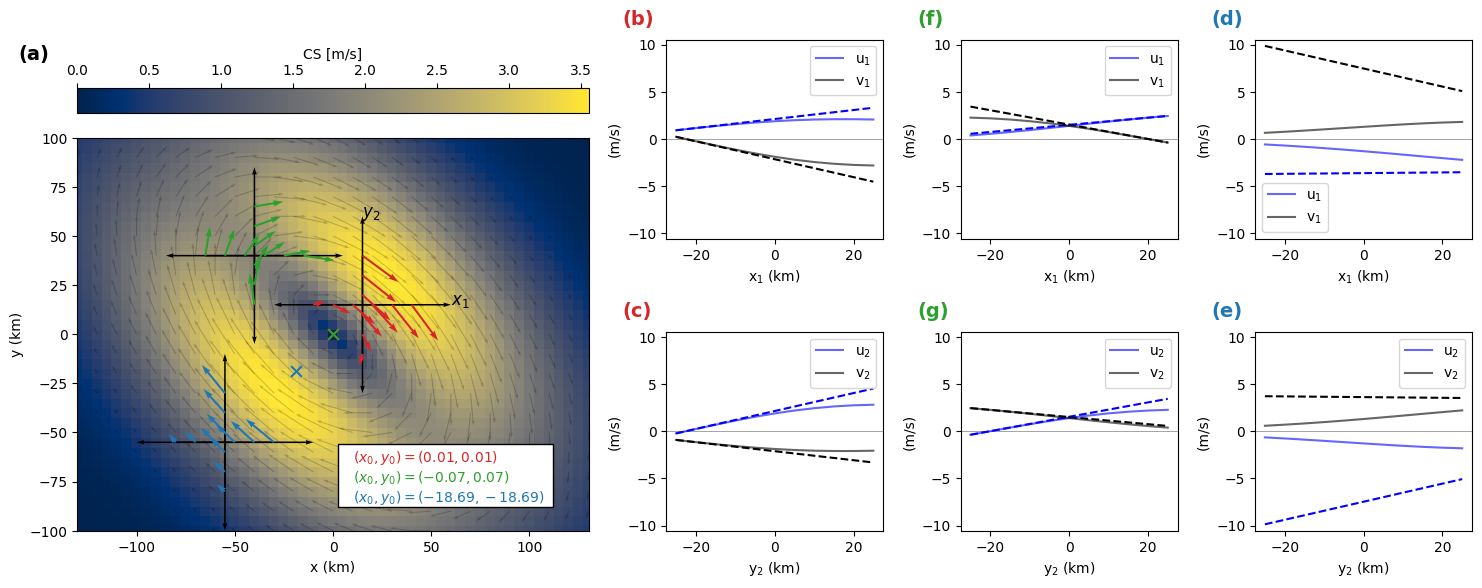

In [15]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i])
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

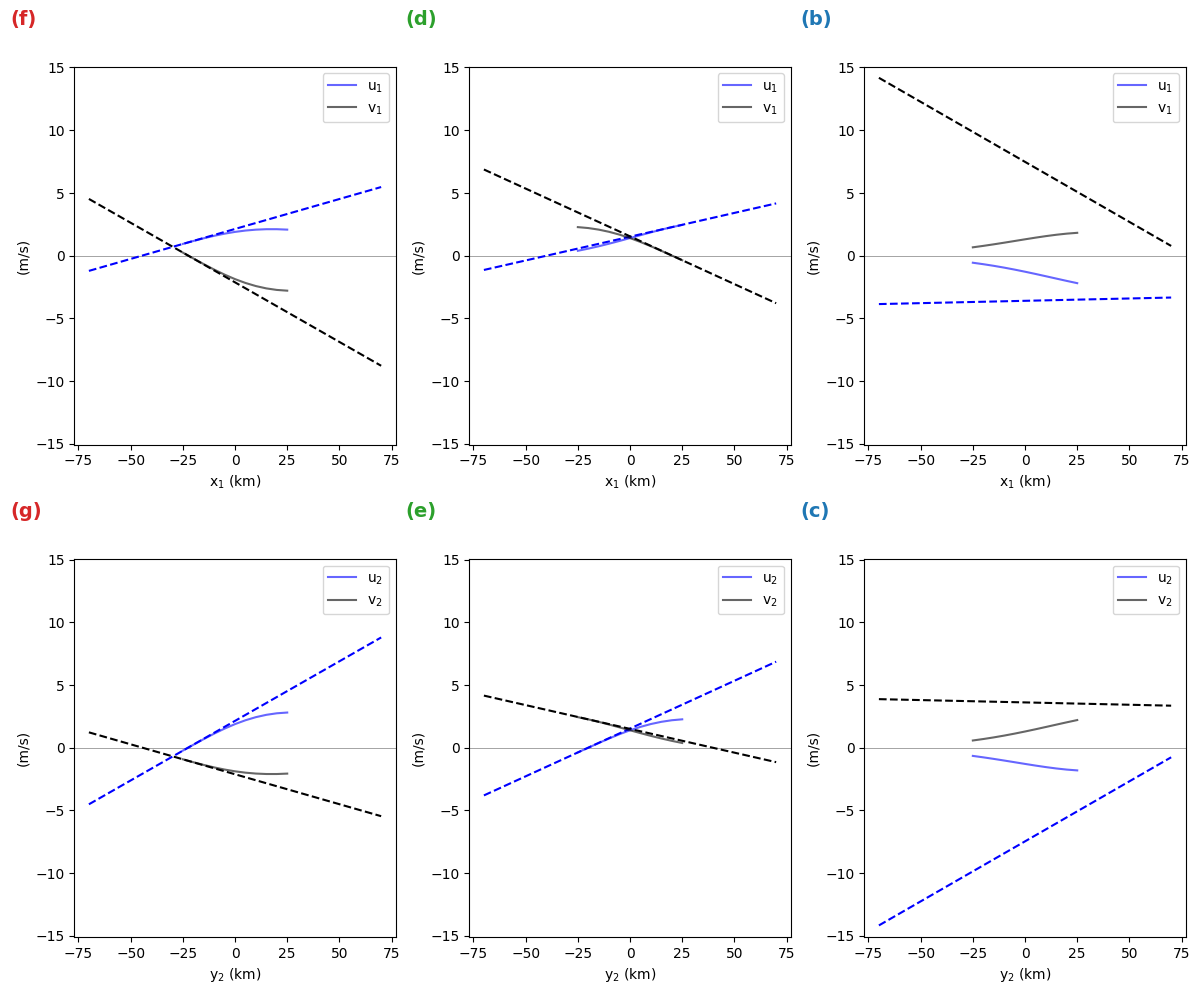

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(12,10))
j = 0
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]

l = np.linspace(-70, 70, 100)
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = axs[0, j]
        ax3 = axs[1, j]
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*l + A0
        p_v1 = B1*l + B0

        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*l + C0
        p_v2 = D1*l + D0
    
        ax2.plot(l, p_u1, 'b--')#, color=colours[i])
        ax2.plot(l, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(l, p_u2, 'b--')#, color=colours[i])
        ax3.plot(l, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs.flat), max(ax.get_ylim()[1] for ax in axs.flat)
for ax in axs.flat:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

0.17739536970799286 0.17739536970799286
0.013369631894477152 0.013369631894477152
-0.17663705389286655 -0.17663705389286655


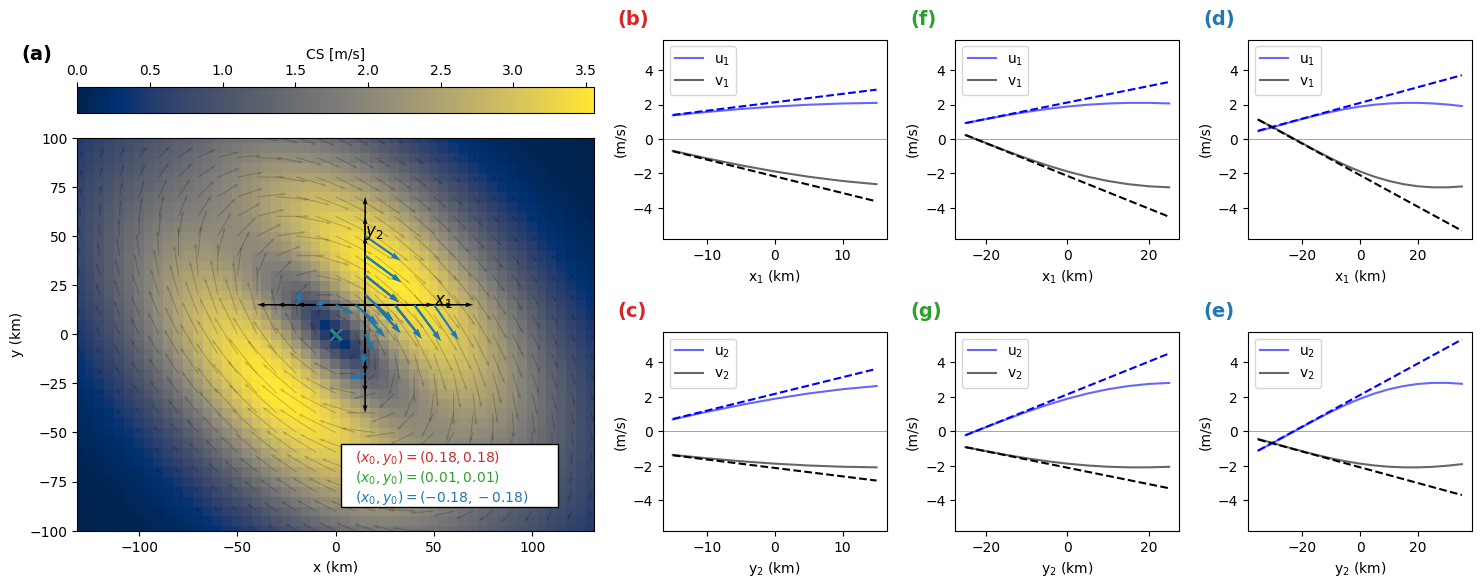

In [17]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [m/s]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

colours = plt.cm.tab10.colors
colours = [colours[3], colours[2], colours[0]]
i = 0
for dic in dic_tests_mod.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax_main.quiver(x1[0], y1[0], x1[-1]-x1[0] + 20, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x1[-1], y1[-1], -(x1[-1]-x1[0] + 20), 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[0], y2[0], 0, y2[-1]-y2[0] + 20, angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.quiver(x2[-1], y2[-1], 0, -(y2[-1]-y2[0] + 20), angles='xy', scale_units='xy', scale=1, color='k', width=0.003)
        ax_main.text(x1[-1] + 20, y1[-1], r'$x_1$' if '1' in dic['name'] else '', fontsize=12)
        ax_main.text(x2[-1], y2[-1] + 20, r'$y_2$' if '1' in dic['name'] else '', fontsize=12)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(x0, y0, marker='x', s=60, color=colours[i])
        ax_main.text(10, -65 - 10*i, fr'$(x_0,y_0)=({x0:.2f},{y0:.2f})$', color=colours[i])
        print(x0, y0)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black')
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)'), ('(d)','(e)'), ('(f)','(g)')]
for dic in dic_tests_mod.values():
    if 'L' in dic['name']:

        x0, y0, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = (dic[k] for k in ['x0', 'y0', 'w', 'x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2', 'xx', 'yy'])

        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(xx, v1)
        A1, A0 = tang_at_root(xx, u1, root_x)
        B1, B0 = tang_at_root(xx, v1, root_x)
        p_u1 = A1*xx + A0
        p_v1 = B1*xx + B0

        root_y = find_root(yy, u2)
        C1, C0 = tang_at_root(yy, u2, root_y)
        D1, D0 = tang_at_root(yy, v2, root_y)
        p_u2 = C1*yy + C0
        p_v2 = D1*yy + D0
    
        ax2.plot(xx, p_u1, 'b--')#, color=colours[i])
        ax2.plot(xx, p_v1, 'k--',)#, color=colours[i+1])
        ax2.plot(xx, u1, 'b', label=r'u$_1$', alpha=.6)#, color=colours[i])
        ax2.plot(xx, v1, 'k', label=r'v$_1$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(m/s)')
        ax2.set_xlabel(r'x$_1$ (km)')
        ax2.legend(loc='best')
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])
        
        ax3.plot(yy, p_u2, 'b--')#, color=colours[i])
        ax3.plot(yy, p_v2, 'k--')#, color=colours[i+1])
        ax3.plot(yy, u2, 'b', label=r'u$_2$', alpha=.6)#, color=colours[i])
        ax3.plot(yy, v2, 'k', label=r'v$_2$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(m/s)')
        ax3.set_xlabel(r'y$_2$ (km)')
        ax3.legend(loc='best')
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## Error Map

In [18]:
%%capture

df_error = pd.DataFrame(columns=['Boundary', 'i', 'j', 'r', 'xc', 'yc', 'Error'])

for boundary in [35, 40, 45]:
    for i in range(boundary, u.shape[0] - boundary):
        for j in range(boundary, u.shape[1] - boundary):
    
            for r_rel in range(1, 10):
    
                x0_rel, y0_rel, _, _, _, _, _, _, _, _, _, _, _ = moca2_mod(i, j, r_rel, u, v, X, Y)
                err = np.hypot(x0_rel, y0_rel)
        
                df_error.loc[len(df_error)] = {'Boundary': boundary, 'i': i, 'j': j, 'r': r_rel, 'xc': x0_rel, 'yc': y0_rel, 'Error': err}
            

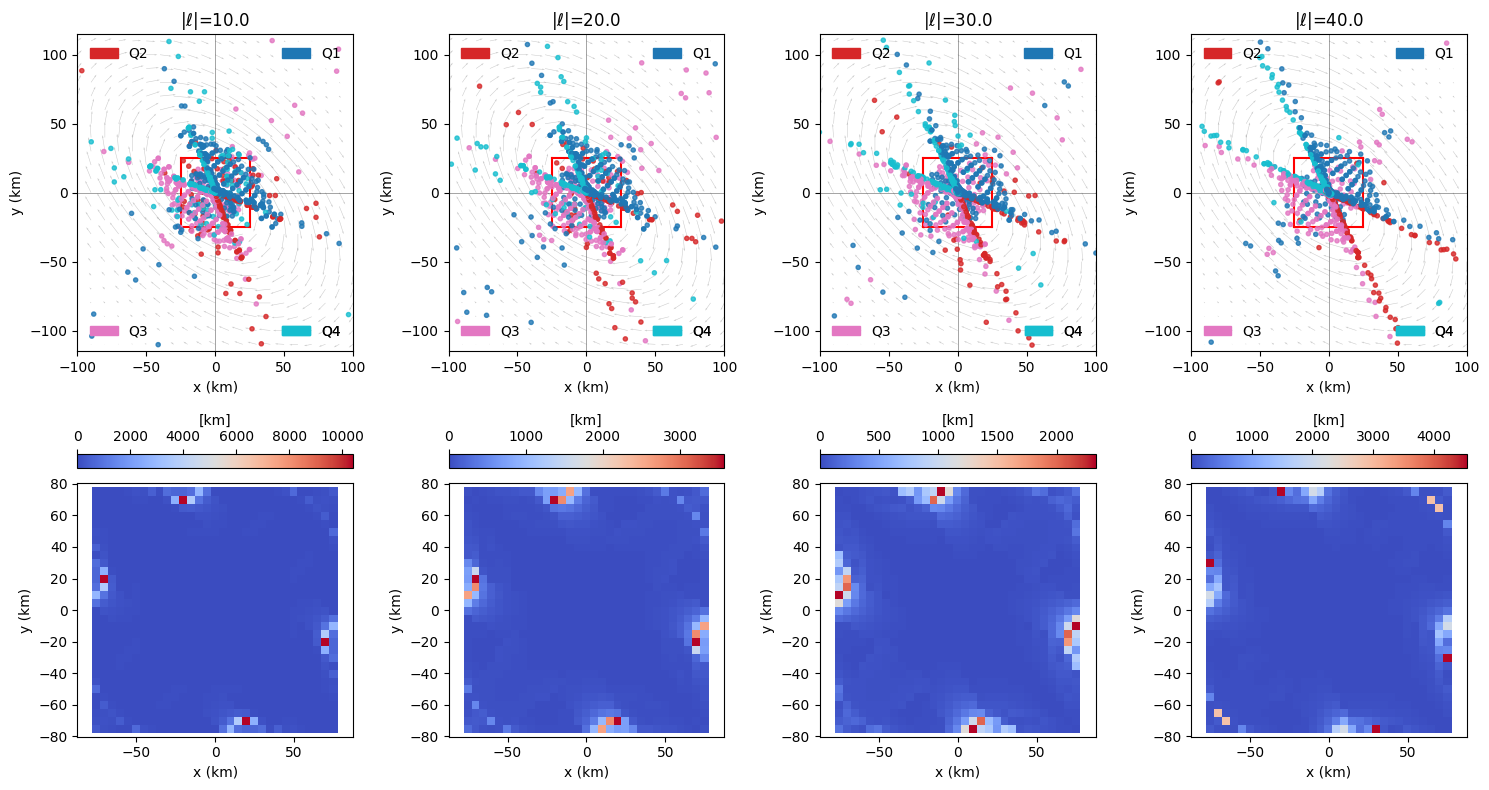

In [19]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(2, 4, figsize=(15,8))

dx = x[1] - x[0]
for i, r_check in enumerate([2, 4, 6, 8]):

    axs[0,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width, zorder=0)

    axs[0,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    axs[0,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
    axs[0,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    axs[0,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
    
    df_rel = df_error.loc[df_error['r'] == r_check].copy()

    def get_quadrant(i, j, center):
        if i >= center[0] and j >= center[1]:
            return 1  # Top-right
        elif i < center[0] and j >= center[1]:
            return 2  # Top-left
        elif i < center[0] and j < center[1]:
            return 3  # Bottom-left
        else:
            return 4  # Bottom-right
    
    df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)

    # Define legend locations
    legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
    scatter = axs[0, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
    unique_q = np.append(df_rel['Q'].unique(),0)
    for q in unique_q:
        if q in legend_locs:
            handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
            legend = axs[0, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
            axs[0, i].add_artist(legend)  # Keep adding legends instead of replacing
        else:
            handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
            legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
            legend.set_visible(False)
        
    axs[0,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    axs[0,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    
    axs[0,i].axis('equal')
    axs[0,i].set_xlim(-100, 100)
    axs[0,i].set_ylim(-100, 100)
    axs[0,i].set_title(fr'$|\ell|$={r_check*dx}')
    axs[0,i].set_xlabel('x (km)')
    axs[0,i].set_ylabel('y (km)')

    # plot2
    
    x_unique = np.unique(x[df_rel['i']])
    y_unique = np.unique(y[df_rel['j']])
    
    z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
    
    # Fill the 2D z array with the corresponding z values
    for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_2d[y_idx, x_idx] = zi
    
    pcl = axs[1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=None, cmap='coolwarm')
    cbar = plt.colorbar(pcl, ax=axs[1, i], orientation='horizontal', location='top', label='[km]')
    axs[1,i].axis('equal')

    axs[1,i].set_xlabel('x (km)')
    axs[1,i].set_ylabel('y (km)')
    
plt.tight_layout()
plt.show()

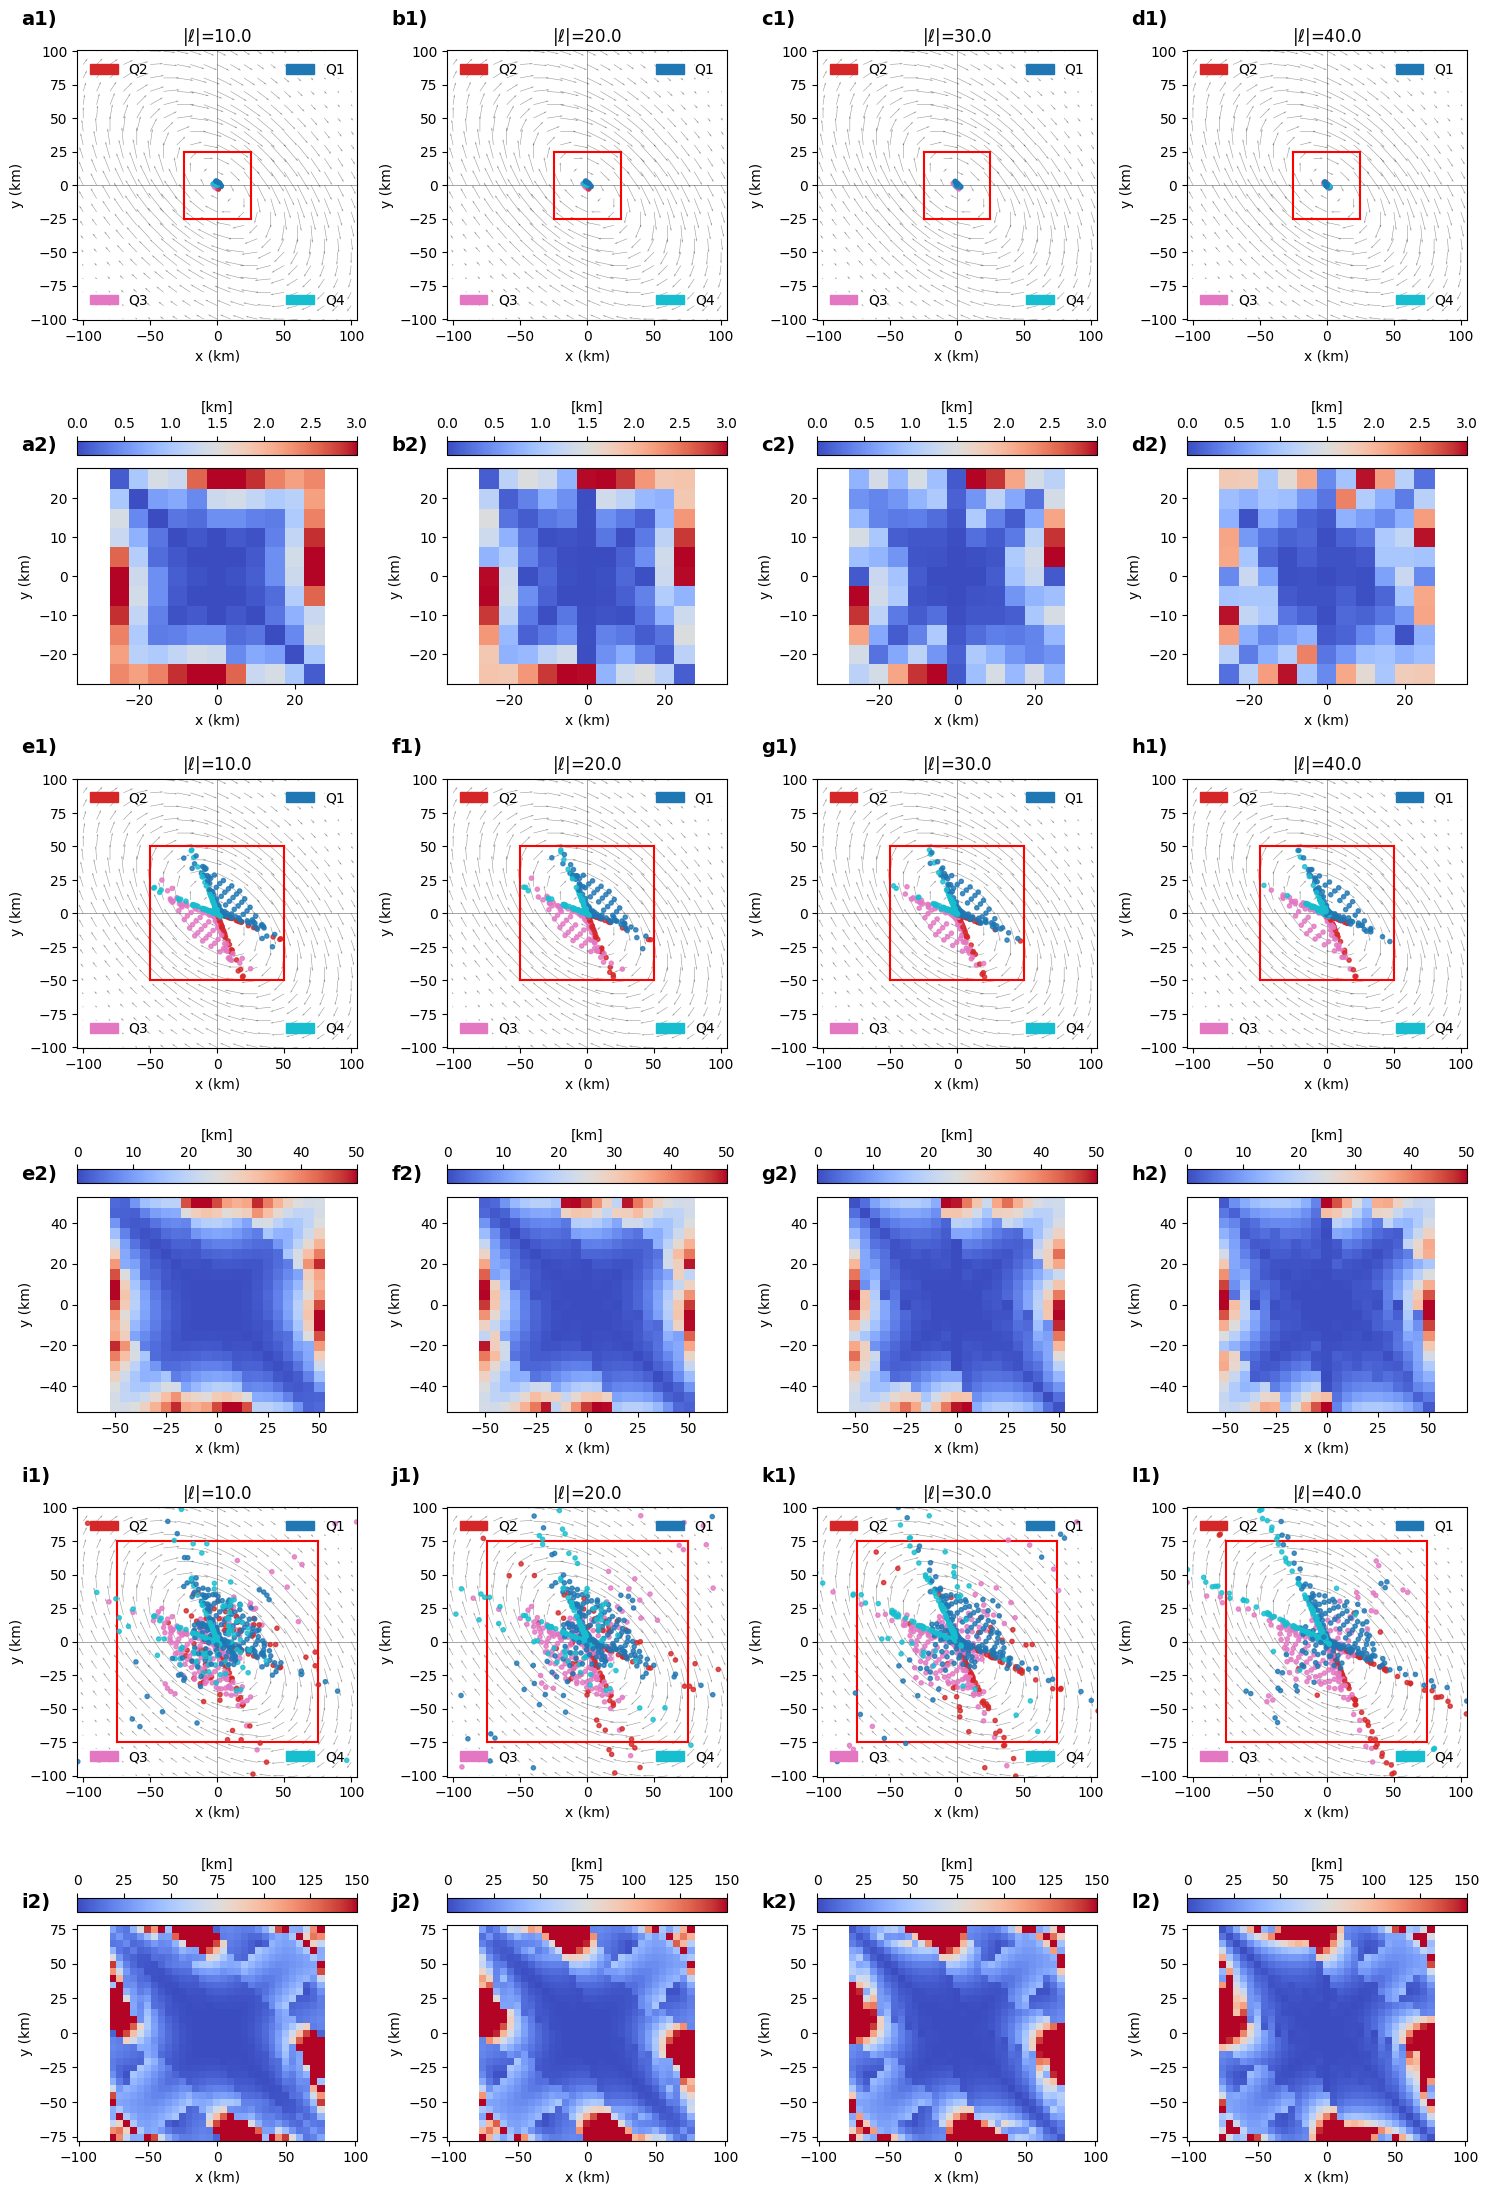

In [41]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(6, 4, figsize=(15,22))

tgs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

vmaxs = [3, 50, 150]
dx = x[1] - x[0]
for i, r_check in enumerate([2, 4, 6, 8]):

    for j, boundary in enumerate(np.flip(df_error['Boundary'].unique())):    
    
        axs[2*j,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
                   alpha=0.4, scale=scale, width=width, zorder=0)
    
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        
        df_rel = df_error.loc[(df_error['r'] == r_check) & (df_error['Boundary'] == boundary)].copy()
    
        def get_quadrant(i, j, center):
            if i >= center[0] and j >= center[1]:
                return 1  # Top-right
            elif i < center[0] and j >= center[1]:
                return 2  # Top-left
            elif i < center[0] and j < center[1]:
                return 3  # Bottom-left
            else:
                return 4  # Bottom-right
        
        df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)
    
        # Define legend locations
        legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
        scatter = axs[2*j, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
        unique_q = np.append(df_rel['Q'].unique(),0)
        for q in unique_q:
            if q in legend_locs:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
                axs[2*j, i].add_artist(legend)  # Keep adding legends instead of replacing
            else:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
                legend.set_visible(False)

        axs[2*j,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        axs[2*j,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        
        axs[2*j,i].axis('equal')
        axs[2*j,i].set_xlim(-100, 100)
        axs[2*j,i].set_ylim(-100, 100)
        axs[2*j,i].set_title(fr'$|\ell|$={r_check*dx}')
        axs[2*j,i].set_xlabel('x (km)')
        axs[2*j,i].set_ylabel('y (km)')

        axs[2*j,i].text(-0.2, 1.15, tgs[4*j+i]+'1)', transform=axs[2*j,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
        # plot2
        
        x_unique = np.unique(x[df_rel['i']])
        y_unique = np.unique(y[df_rel['j']])
        
        z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Fill the 2D z array with the corresponding z values
        for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
            x_idx = np.where(x_unique == xi)[0][0]
            y_idx = np.where(y_unique == yi)[0][0]
            z_2d[y_idx, x_idx] = zi
        
        pcl = axs[2*j+1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=vmaxs[j], cmap='coolwarm')
        cbar = plt.colorbar(pcl, ax=axs[2*j+1, i], orientation='horizontal', location='top', label='[km]')
        axs[2*j+1,i].axis('equal')
    
        axs[2*j+1,i].set_xlabel('x (km)')
        axs[2*j+1,i].set_ylabel('y (km)')

        axs[2*j+1,i].text(-0.2, 1.15, tgs[4*j+i]+'2)', transform=axs[2*j+1,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
plt.tight_layout()
plt.show()

In [32]:
dx

np.float64(5.0)